<a href="https://colab.research.google.com/github/aditi6/Meta-RL/blob/main/A2C_RNN_Dependent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

# Base class for bandit environment
class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations

    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    """
    def __init__(self, p_dist, r_dist):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.state_space = spaces.Discrete(1)

        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        done = True
        reward = 0

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done, {}

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass


class BanditTwoArmedIndependent(BanditEnv):
    """Simplest case where one bandit always pays, and the other always doesn't"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[np.random.rand(1), np.random.rand(1)], r_dist=[1, 1])

class BanditTwoArmedDependentUniform(BanditEnv):
    """Simplest case where one bandit always pays, and the other always doesn't"""
    def __init__(self):
        p1=np.random.rand(1)
        BanditEnv.__init__(self, p_dist=[p1, 1-p1], r_dist=[1, 1])


class BanditTwoArmedEasy(BanditEnv):
    """Stochastic version with a large difference between which bandit pays out of two choices"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.9, 0.1], r_dist=[1, 1])


class BanditTwoArmedMedium(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are good"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.25, 0.75], r_dist=[1, 1])


class BanditTwoArmedHard(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are bad"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.1, 0.2], r_dist=[1, 1])


class BanditTenArmedRandomFixed(BanditEnv):
    """10 armed bandit with random probabilities assigned to payouts"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.full(bandits, 1)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedUniformDistributedReward(BanditEnv):
    """10 armed bandit with that always pays out with a reward selected from a uniform distribution"""
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedRandomRandom(BanditEnv):
    """10 armed bandit with random probabilities assigned to both payouts and rewards"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)

    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for _ in range(bandits):
            r_dist.append([np.random.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import torch.optim as optim
import matplotlib.pyplot as plt

# Neural Network definition for A2C (LSTM)
class A2C(nn.Module):

    def __init__(self, in_size=4, hidden_size=48, batch_size=1, gamma=.99, random_seed=None):
        """
        env: target gym environment
        gamma: the discount factor parameter for expected reward function :float
        random_seed: random seed for experiment reproducibility :float, int, str
        """
        super().__init__()

        if random_seed:
          env.seed(random_seed)
          torch.manual_seed(random_seed)

        # class variables
        #self.env = env
        self.in_size = in_size
        self.hidden_size = hidden_size  # hidden size of LSTM
        self.out_size = 2  # output size is number of actions in action space
        self.batch_size = batch_size
        self.gamma = gamma  # discount factor

        # neural network
        self.lstm = nn.LSTM(input_size=self.in_size,
                            hidden_size=self.hidden_size,
                            batch_first=True)
        self.probs = nn.Sequential(  # Actor head
                        nn.Linear(self.hidden_size, self.out_size),
                        nn.Softmax(dim=self.out_size)
                    )
        self.val = nn.Linear(self.hidden_size, 1)  # Critic head

    def forward(self, input, hidden=None):
        """
        input: (1, 1, in_size) so that LSTM is like a single cell. in_size: [prev_reward, normalized_time, action_vector]
        output: categorical object to sample from, value function estimate
        """
        lstm_out, hidden = self.lstm(input, hidden)  # hidden state, cell state initialized to 0s if hidden=None

        policy_out = self.probs(lstm_out)
        val_out = self.val(lstm_out)

        return Categorical(policy_out), val_out, hidden

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# helper functions

def normalize_time(t, T, min_lim=-1, max_lim=1, horizon=False):
    """ Normalize time input to lie relative in [min_lim, max_lim]. """
    # Decay down from max_lim to min_lim as t -> T
    if horizon:
        return (min_lim - max_lim) * (t - T) / T + min_lim
    # Decay up from min_lim to max_lim as t -> T
    else:
        return (max_lim - min_lim) * t/ T + min_lim

def one_hot_encode(vec_dim, index):
    """ Encode index as one hot - set dim to 1 all others to 0. """
    out = torch.zeros(vec_dim)
    out[index] = 1
    return out

def l2t(l):
    """ Converts a list to a tensor """
    return torch.stack(tuple(l), 0)


def compute_returns(final_val, rewards, gamma):
    """
    Computes all the returns
    - returns[-1] = r_T + gamma*final_val
    - returns[-2] = r_T-1 + gamma*r_T + gamma**2*final_val
    ....
    - returns[0] = sum_{t=1}^T gamma*{t-1} r_t + gamma**T*final_val
    """
    returns = []
    R = final_val
    for r in reversed(rewards):
        R = r + gamma * R
        returns.append(R)
    return returns[::-1]

def expected_reward(a,p_dist):
  if a==torch.tensor([[0]]):
    r=p_dist[0]
  else:
    r=p_dist[1]
  return r

#env = BanditTwoArmedIndependent()
#print(env.p_dist)
#print(expected_reward(1,env.p_dist))



In [ ]:
def run_ep(env, net, gamma, num_arms=2, tmax=100):
    """
    runs the network for an episode (50 steps by default)
    """
    t = env.reset()  # set t to 0 at the beginning of an episode
    action_hist, log_probs, values, rewards, entropy, cum_reg_array = [], [], [], [], [], []
    cum_reg=0

    while t < tmax + 1:  # Just so we can get last input. Break when t == tmax later
        if t == 0:
            r, time, a = (torch.tensor([0], dtype=torch.float32),
                          torch.tensor([normalize_time(t, tmax)], dtype=torch.float32),
                          one_hot_encode(num_arms, 0))
            input = torch.cat((r, time, a)).view(1, 1, -1)  # .view changes the shape to (1, 1, 4) so it can be passed to LSTM
            hidden = None  # ensures that LSTM uses hidden state initialized to 0s
        else:
            r, time, a = (torch.tensor([rewards[-1]], dtype=torch.float32),
                          torch.tensor([normalize_time(t, tmax)], dtype=torch.float32),
                          one_hot_encode(num_arms, action_hist[-1]))
            input = torch.cat((r, time, a)).view(1, 1, -1)

        if t == tmax:
            break

        policy_out, val_out, hidden = net(input, hidden)  # pass input through network
        action = policy_out.sample()  # get action
        state, reward, done, info = env.step(action.item())  # get reward from environment
        log_prob = policy_out.log_prob(action)
        cum_reg=cum_reg+max(env.p_dist)-expected_reward(action,env.p_dist)

        t += 1

        action_hist.append(action)
        log_probs.append(log_prob)
        values.append(val_out.view(-1))
        rewards.append(reward)
        entropy.append(policy_out.entropy().view(-1))
        cum_reg_array.append(cum_reg)


    _, final_val, _ = net(input, hidden)
    returns = compute_returns(final_val, rewards,gamma)
    # Standardize returns
    returns = l2t(returns)
    returns = (returns - torch.mean(returns)) / (torch.std(returns) + .000000000001)
    #print(cum_reg_array)

    return action_hist, l2t(log_probs), l2t(values), returns, l2t(entropy), rewards, cum_reg_array

def compute_loss(log_probs, returns, vals, entropy, beta_e=0.5, beta_v=0.05):
        """
        Actor Advantage Loss, where advantage = returns - vals
        Critic Loss, using mean squared error
        :param critic_loss: loss function for critic   :Pytorch loss module
        :param log probs: Action Log Probabilities  :Tensor
        :param returns: Actual Expected Returns   :Tensor
        :param vals: Predicted Expected Returns    :Tensor
        :return: Actor loss tensor, Critic loss tensor  :Tensor
        """
        assert len(log_probs) == len(returns) == len(vals)
        advantage=returns-vals
        a_loss = -(log_probs * advantage.detach()).mean()
        c_loss = advantage.pow(2).mean()

        actor_loss = a_loss.mean()
        critic_loss = c_loss.mean()
        entropy_loss = entropy.mean()

        full_loss = actor_loss + beta_v*critic_loss - beta_e*entropy_loss

        return (full_loss)

In [ ]:


def reg_function(x):
  import torch.optim as optim
  env = BanditTwoArmedEasy()
  net = A2C()
  LR, MAX_EPISODES = x[0], 200
  gamma=x[1]

  optim = optim.Adam(net.parameters(), lr=LR)
  r, a = [], []
  for i in range(MAX_EPISODES):
    optim.zero_grad()

    action_hist, log_probs, values, returns, entropy, rewards, cum_reg_array = run_ep(env, net, gamma)


    total_loss = compute_loss(log_probs, returns, values, entropy)
    total_loss.backward()

    optim.step()

  env = BanditTwoArmedDependentUniform()
  LR, MAX_EPISODES = 0, 5

  cum_reg_avg=0

  net.eval()
  with torch.no_grad():
    for i in range(MAX_EPISODES):

      action_hist, log_probs, values, returns, entropy, rewards, cum_reg_array  = run_ep(env, net, gamma)
      cum_reg_avg=cum_reg_avg+cum_reg_array[-1]

    cum_reg_avg=cum_reg_avg/MAX_EPISODES

  return(cum_reg_avg)



In [ ]:
#!pip install pybads
from pybads.bads import BADS

target = reg_function;

lower_bounds = np.array([0, 0])
upper_bounds = np.array([1, 1])
plausible_lower_bounds = np.array([0.001, 0.5])
plausible_upper_bounds = np.array([0.2, 0.9])
x0 = np.array([0.01, 0.8]);

bads = BADS(target, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds)
optimize_result = bads.optimize()
print(optimize_result['x'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 10.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
INFO:BADS:Beginning optimization of a STOCHASTIC objective function

INFO:BADS: Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
INFO:BADS:     0           2         42.8828             nan               1                                  Uncertainty test
INFO:BADS:     0          34        0.862775             nan               1          Initial mesh            Initial points
INFO:BADS:     0          37        0.862775               1             0.5          Refine grid             Train
INFO:BADS:     1          44        0.862775               1            0.25          Refine grid             Train
INFO:BADS:     2          52         1.21165         0.96739           0.125          Refine grid      

KeyboardInterrupt: ignored

NameError: ignored

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
env = BanditTwoArmedMedium()
net = A2C()
LR, MAX_EPISODES = 0.05, 500
gamma=0.95
#cum_reg_sum=np.zeros(100)

optim = optim.Adam(net.parameters(), lr=LR)
r, a = [], []
for i in range(MAX_EPISODES):
    optim.zero_grad()

    action_hist, log_probs, values, returns, entropy, rewards, cum_reg_list = run_ep(env, net, gamma)
    #cum_reg_array=np.array(cum_reg_list).flatten()
    #cum_reg_sum=cum_reg_sum+cum_reg_array


    total_loss = compute_loss(log_probs, returns, values, entropy)
    total_loss.backward()

    optim.step()


#cum_reg_avg=cum_reg_sum/MAX_EPISODES


env = BanditTwoArmedDependentUniform()
LR, MAX_EPISODES = 0, 100

cum_reg_sum=np.zeros(100)

net.eval()
with torch.no_grad():
    for i in range(MAX_EPISODES):

      action_hist, log_probs, values, returns, entropy, rewards, cum_reg_array  = run_ep(env, net, gamma)
      cum_reg_array=np.array(cum_reg_list).flatten()
      cum_reg_sum=cum_reg_sum+cum_reg_array

cum_reg_avg_nn=cum_reg_sum/MAX_EPISODES
print(cum_reg_avg_nn)



[ 0.5  0.5  0.5  0.5  1.   1.5  2.   2.5  2.5  2.5  2.5  3.   3.5  3.5
  3.5  3.5  3.5  3.5  4.   4.5  4.5  4.5  4.5  4.5  5.   5.5  6.   6.
  6.5  6.5  7.   7.5  8.   8.5  9.   9.   9.   9.5  9.5 10.  10.  10.
 10.5 11.  11.  11.  11.5 12.  12.  12.  12.  12.  12.  12.  12.  12.5
 12.5 12.5 13.  13.5 13.5 14.  14.  14.5 15.  15.  15.5 16.  16.  16.
 16.5 16.5 16.5 16.5 17.  17.  17.5 17.5 17.5 18.  18.  18.5 18.5 19.
 19.5 20.  20.  20.5 21.  21.5 21.5 21.5 22.  22.5 22.5 23.  23.5 23.5
 24.  24. ]


In [ ]:
# Bandit functions for UCB and TS
import random

def Dependent(i,p):
    r=0
    x=random.uniform(0,1)
    if((i==1)&(x<p)):
        r=1
    if((i==2)&(x<(1-p))):
       r=1
    return r


def Independent(i,p1,p2):
    r=0
    x=random.uniform(0,1)
    if((i==1)&(x<p1)):
        r=1
    if((i==2)&(x<p2)):
       r=1
    return r

def Easy(i):
    r=0
    x=random.uniform(0,1)
    if((i==1)&(x<0.1)):
        r=1
    if((i==2)&(x<0.9)):
       r=1
    return r

def Medium(i):
    r=0
    x=random.uniform(0,1)
    if((i==1)&(x<0.25)):
        r=1
    if((i==2)&(x<0.75)):
       r=1
    return r

def Hard(i):
    r=0
    x=random.uniform(0,1)
    if((i==1)&(x<0.4)):
        r=1
    if((i==2)&(x<0.6)):
       r=1
    return r

In [ ]:
# UCB
import math

regsum=np.zeros(100)
l=0

while(l<1000):
    p=random.uniform(0,1)
    e=max(p,1-p)

    reg=np.zeros(100)
    trial=np.zeros(100)

    x1=Dependent(1,p)
    x2=Dependent(2,p)
    n1=1
    n2=1
    n=2

    t=0
    while t<100:
        m1=x1+math.sqrt(1*math.log(n)/n1)
        m2=x2+math.sqrt(1*math.log(n)/n2)
        if(m1>=m2):
            i=1
            r=Dependent(i,p)
            x1=(x1*n1+r)/(n1+1)
            n1=n1+1
        else:
            i=2
            r=Dependent(i,p)
            x2=(x2*n2+r)/(n2+1)
            n2=n2+1
        n=n+1
        reg[t]=reg[t-1]+e-r
        trial[t]=trial[t-1]+1
        t=t+1
    regsum=regsum+reg
    l=l+1

regavg_ucb=regsum/1000


In [ ]:
# TS

regsum=np.zeros(100)
n=0
while(n<1000):

    a1=1
    a2=1
    b1=1
    b2=1

    p=random.uniform(0,1)
    e=max(p,1-p)

    reg=np.zeros(100)
    trial=np.zeros(100)

    t=0
    while t<100:
        x1=np.random.beta(a1,b1)
        x2=np.random.beta(a2,b2)

        if(x1>=x2):
            i=1
            r=Dependent(i,p)
            if(r==1):
                a1=a1+1
            else:
                b1=b1+1
        else:
            i=2
            r=Dependent(i,p)
            if(r==1):
                a2=a2+1
            else:
                b2=b2+1
        reg[t]=reg[t-1]+e-r
        trial[t]=trial[t-1]+1
        t=t+1
    regsum=regsum+reg
    n=n+1

regavg_ts=regsum/1000

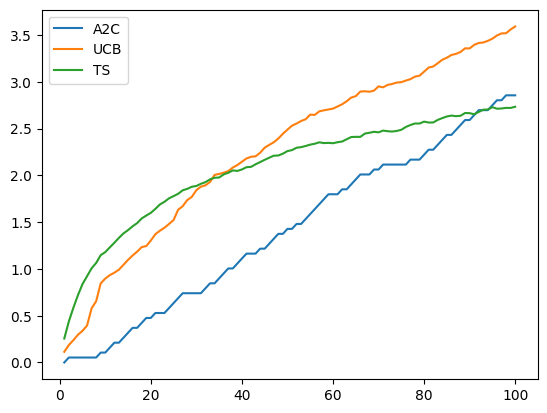

In [ ]:
# Plots
plt.plot(trial,cum_reg_avg_nn)
plt.plot(trial,regavg_ucb)
plt.plot(trial,regavg_ts)
plt.legend(['A2C','UCB','TS'])
plt.show()
